In [ ]:
import copy
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [ ]:
!conda install --yes --prefix {sys.prefix} pytorch torchvision torchaudio -c pytorch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

# Load Data

In [ ]:
def load_data(train_label_path, test_label_path, train_data_path, test_data_path):
    PATH_TO_SAVED_DATA = os.getcwd() + "/Processed Data/"

    # Load Data
    train_labels = pickle.load(open(PATH_TO_SAVED_DATA + train_label_path, "rb"))
    test_labels = pickle.load(open(PATH_TO_SAVED_DATA + test_label_path, "rb"))
    train_data = pickle.load(open(PATH_TO_SAVED_DATA + train_data_path, "rb"))
    test_data = pickle.load(open(PATH_TO_SAVED_DATA + test_data_path, "rb"))
    
    # Convert labels to same format as data
    train_labels = np.asarray([[label] for label in train_labels])
    test_labels = np.asarray([[label] for label in test_labels])
    
    # Convert data and labels to tensors
    dtype = torch.FloatTensor
    train_data = Variable(torch.from_numpy(train_data).type(dtype), requires_grad=False)
    train_labels = Variable(torch.from_numpy(train_labels).type(dtype), requires_grad=False)
    test_data = Variable(torch.from_numpy(test_data).type(dtype), requires_grad=False)
    test_labels = Variable(torch.from_numpy(test_labels).type(dtype), requires_grad=False)
    
    # Print confirmation of data and label size
    print("Training labels size:", train_labels.size())
    print("Testing labels size:", test_labels.size())
    print("Training data size:", train_data.size())
    print("Testing data size:", test_data.size())
    
    return train_labels, test_labels, train_data, test_data

In [ ]:
train_labels, test_labels, train_data, test_data = load_data("train_labels.p", 
                                                             "test_labels.p", 
                                                             "train_data.p", 
                                                             "test_data.p")

# Train, Test, and Evaluate Models

In [ ]:
def graphResults(epoch, loss, f1, auc):
    """Graph the loss, f1 score, and AUC over each epoch during training.
    
    Keyword arguments:
    epoch -- the number of training iterations
    loss -- array of size [epoch] containing the loss value of each iteration
    f1 -- array of size [epoch] contianing the f1 value of each iteration
    auc -- array of size [epoch] contianing the auc of each iteration
    """
    plt.figure()
    iterations = np.arange(epoch)
    plt.plot(iterations, loss)
    plt.title("Loss During Training")

    plt.figure()
    iterations = np.arange(epoch)
    plt.plot(iterations, f1)
    plt.title("F1 During Training")
    
    plt.figure()
    iterations = np.arange(epoch)
    plt.plot(iterations, auc)
    plt.title("AUC During Training")

    print("Best F1 Epoch:", list(f1).index(max(f1)))
    print("Best AUC Epoch:", list(auc).index(max(auc)))
    

def test(model, test_data, test_labels):
    y_pred = model.forward(test_data)
    y_pred = np.asarray(y_pred.detach().numpy())
    y_score = y_pred
    y_pred = y_pred >= 0.5
    y_pred = y_pred.astype(int)

    y_true = np.asarray(test_labels.detach().numpy())
    
    return y_true, y_pred, y_score
    
    
def trainModel(epoch, model, train_data, train_labels, test_data, test_labels, debug=0):
    """Perform training on the given model.
    
    Keyword arguments:
    epoch -- number of training iterations
    model -- MLP model to train
    train_data, train_labels -- labeled training data
    test_data, test_labels -- labeled testing data
    debug -- controls whether or not loss is printed during training (default 0)
    """
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)
    
    
    loss = np.zeros(epoch)
    f1 = np.zeros(epoch)
    auc = np.zeros(epoch)
    models = []

    for t in range(epoch):
        # Forward pass to compute predictions using training_data
        y_pred = model.forward(train_data)

        # Compute and print loss
        loss_var = criterion(y_pred, train_labels)
        loss[t] = loss_var.item()
        
        # Print loss progress every 1000 iterations
        if debug:
            if t % 1000 == 0:
                print(t, loss_var.item())
        
        # Test iteration
        y_true, y_pred, y_score = test(model, test_data, test_labels)
        #y_pred = model.forward(test_data)
        #y_pred = np.asarray(y_pred.detach().numpy())
        #y_score = y_pred
        #y_pred = y_pred >= 0.5
        #y_pred = y_pred.astype(int)
        #y = np.asarray(test_labels.detach().numpy())
        
        # Save iteration metrics
        auc[t] = metrics.roc_auc_score(y_true, y_score)
        f1[t] = metrics.f1_score(y_true, y_pred)
        models.append(copy.deepcopy(model))

        # Zero gradients, perform backward pass, and update weights
        optimizer.zero_grad()
        loss_var.backward()
        optimizer.step()
        
    return models, loss, f1, auc

## Define and Train the Model

Best F1 Epoch: 451
Best AUC Epoch: 0


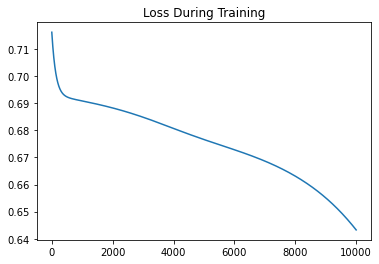

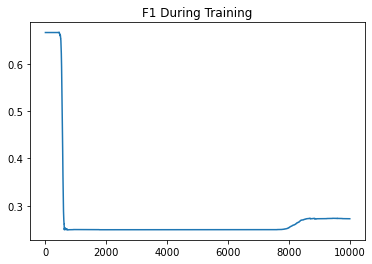

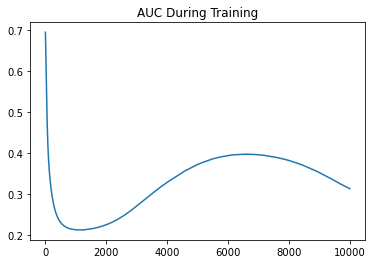

In [7]:
D_in = len(train_data[0])
H1 = 20
H2 = 1
D_out = 1
epoch = 10000

model = nn.Sequential(nn.Linear(D_in, H1),
                      nn.Linear(H1, H2),
                      nn.Linear(H2, D_out),
                      nn.Sigmoid())

# Get the models, loss, f1, and auc for each iteration
saved_models, saved_loss, saved_f1, saved_auc = trainModel(epoch, 
                                                           model, 
                                                           train_data, 
                                                           train_labels, 
                                                           test_data, 
                                                           test_labels, 
                                                           0)

graphResults(epoch, saved_loss, saved_f1, saved_auc)

# Evaluate Model and Save

In [8]:
y_true, y_pred, y_score = test(saved_models[451], test_data, test_labels)

confusion_matrix = metrics.confusion_matrix(y_true, y_pred, labels=[0,1])
print("Confusion Matrix:\n", confusion_matrix)

accuracy = metrics.accuracy_score(y_true, y_pred)
print("Accuracy: ", accuracy)

precision = metrics.precision_score(y_true, y_pred)
print("Precision:", precision)

recall = metrics.recall_score(y_true, y_pred)
print("Recall:   ", recall)

f1 = metrics.f1_score(y_true, y_pred)
print("F1:       ", f1)

auc = metrics.roc_auc_score(y_true, y_score)
print("AUC:      ", auc)

Confusion Matrix:
 [[  2 747]
 [  0 749]]
Accuracy:  0.5013351134846462
Precision: 0.5006684491978609
Recall:    1.0
F1:        0.667260579064588
AUC:       0.23565020383207874


## Save Models

Saved models are stored in arrays then serialized for use later

In [9]:
# Initialize array to save models (clears previous progress)
models = []

Add the model generated at the specified training iteration to storage

In [10]:
index = 451

models.append(saved_models[index])
print(len(models))

1


Serialize the saved models

In [11]:
path = os.getcwd() + "/Results/"
pickle.dump(models, open(path + "MLP_Models.p", "wb"))